# Load libraries and data

In [63]:
library(dplyr)
library(caret)
library(factoextra)
library(class)
library(tidyr)
library(readr)

Warning message:
“package ‘readr’ was built under R version 3.4.4”

In [2]:
# Training paths
a_train_path = "/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Sensor Classification Project/Dataset/all_raw_data_a_train.csv"
g_train_path = "/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Sensor Classification Project/Dataset/all_raw_data_g_train.csv"
a_test_path = "/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Sensor Classification Project/Dataset/all_raw_data_a_test.csv"
g_test_path = "/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Sensor Classification Project/Dataset/all_raw_data_g_test.csv"

# Training data
data_a_train = read.csv(a_train_path, encoding = "UTF-8")
data_g_train = read.csv(g_train_path, encoding = "UTF-8")

# Testing data
data_a_test = read.csv(a_test_path, encoding = "UTF-8")
data_g_test = read.csv(g_test_path, encoding = "UTF-8")

# Data processing

### 1. Join a_train and g_train

In [3]:
data = merge(data_a_train, data_g_train,
                     by = c("user_id","exp_id","epoch"))

test_data = merge(data_a_test, data_g_test,
                     by = c("user_id", "exp_id", "epoch"))

### 2. Deal with missing data

In [4]:
data = na.omit(data)

Only 1 missing datapoint removed.

### 3. Select relevant features

In [5]:
data = 
    data %>%
    select(user_id:AR12.1.x,
           m1.y:AR12.1.y) %>%
    rename(activity = activity.x,
           sample = sample.x)

test_data = 
    test_data %>%
    select(user_id:AR12.1.x,
           m1.y:AR12.1.y) %>%
    rename(activity = activity.x,
           sample = sample.x)

### 4. Change data structure

In [6]:
data$activity = as.character(data$activity)
test_data$activity = as.character(test_data$activity)

In [7]:
test_data$activity = NA

# Modelling

1. KNN with PCA
2. Multinomial one-vs-all regression
3. LDA with data transformation
4. QDA with data transformation

### 1. KNN with PCA

#### Set aside unncessary columns

In [8]:
# Get unnecessary sections for train/test
KNN_unnecessary = 
    data %>%
    select(user_id:epoch,
           sample)

KNN_unnecessary_test = 
    test_data %>%
    select(user_id:epoch,
           sample)

# Get necessary sections for train/test
KNN_train = 
    data %>%
    select(-user_id:-epoch,
           -sample)

KNN_test = 
    test_data %>%
    select(-user_id:-epoch,
           -sample)

joined = rbind(KNN_train, KNN_test)

#### Get principle components

In [9]:
# PCA data 
PCA_data = 
    joined %>%
    select(-activity)

# PCA fitted
PCA_fitted = prcomp(PCA_data, scale = TRUE)

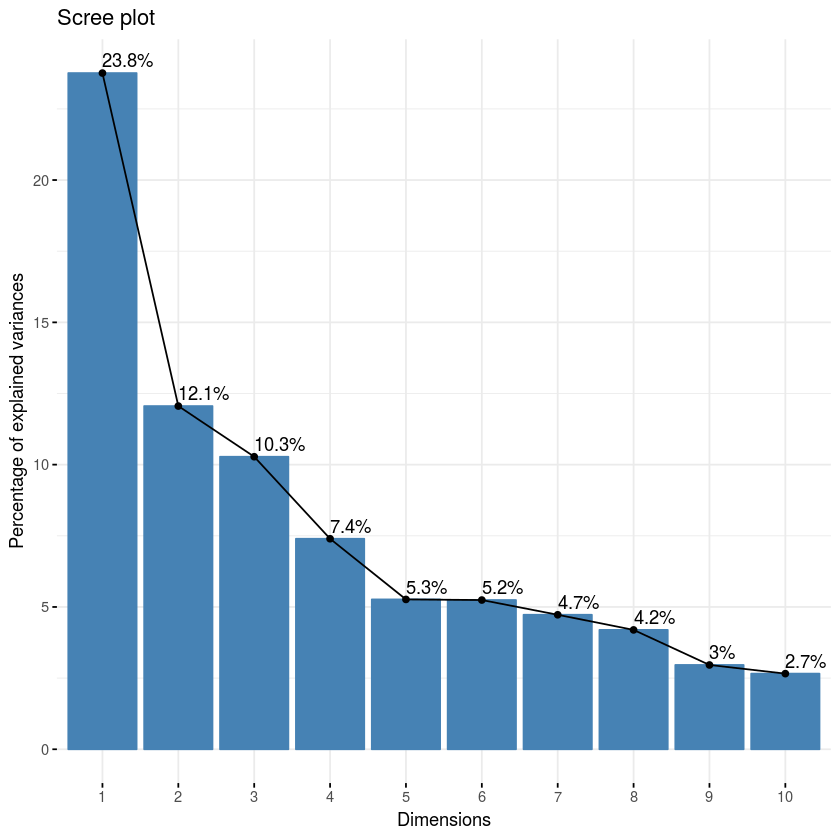

In [10]:
fviz_eig(PCA_fitted, addlabels = TRUE)

Use 5 components - roughly accounts for 60% of the variance of the data.

In [11]:
PCA_scores = as.data.frame(cbind(joined[,1], PCA_fitted$x[,1:5]))
PCA_scores = 
    PCA_scores %>%
    rename(activity = V1)

In [45]:
# Training data
KNN_train =
    PCA_scores %>%
    filter(!is.na(activity)) 

# Test data
KNN_test = 
    PCA_scores %>%
    filter(is.na(activity))

#### Running KNN with 5 principle components

In [13]:
library(doMC) 

# Use parallel processing
registerDoMC(cores = 8) 

# Reset dtypes
KNN_train$activity = as.character(KNN_train$activity)
KNN_train$PC1 = as.numeric(as.character(KNN_train$PC1))
KNN_train$PC2 = as.numeric(as.character(KNN_train$PC2))
KNN_train$PC3 = as.numeric(as.character(KNN_train$PC3))
KNN_train$PC4 = as.numeric(as.character(KNN_train$PC4))
KNN_train$PC5 = as.numeric(as.character(KNN_train$PC5))

# Set cross validation parameters - k = 8, repeats = 5
trControl = trainControl(method  = "repeatedcv",
                          number  = 8,
                          allowParallel = T,
                          repeats = 5)

# Fit the data
KNN_fit = train(activity ~ .,
             method     = "knn",
             tuneGrid   = expand.grid(k = 1:30),
             trControl  = trControl,
             metric     = "Accuracy",
             data       = KNN_train)

Warning message:
“package ‘doMC’ was built under R version 3.4.4”Loading required package: foreach
Warning message:
“package ‘foreach’ was built under R version 3.4.4”Loading required package: iterators
Warning message:
“package ‘iterators’ was built under R version 3.4.4”Loading required package: parallel


In [46]:
KNN_fit

k-Nearest Neighbors 

6251 samples
   5 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (8 fold, repeated 5 times) 
Summary of sample sizes: 5467, 5473, 5468, 5471, 5469, 5470, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.6761189  0.6256697
   2  0.6696547  0.6182943
   3  0.7042702  0.6579789
   4  0.7116288  0.6662447
   5  0.7182227  0.6739254
   6  0.7210682  0.6771658
   7  0.7223131  0.6785555
   8  0.7239749  0.6803911
   9  0.7242317  0.6807538
  10  0.7233991  0.6797686
  11  0.7250614  0.6816756
  12  0.7231107  0.6794331
  13  0.7233989  0.6797288
  14  0.7225040  0.6786327
  15  0.7225373  0.6786984
  16  0.7219612  0.6779902
  17  0.7204554  0.6762494
  18  0.7189837  0.6745530
  19  0.7190490  0.6746121
  20  0.7186015  0.6740911

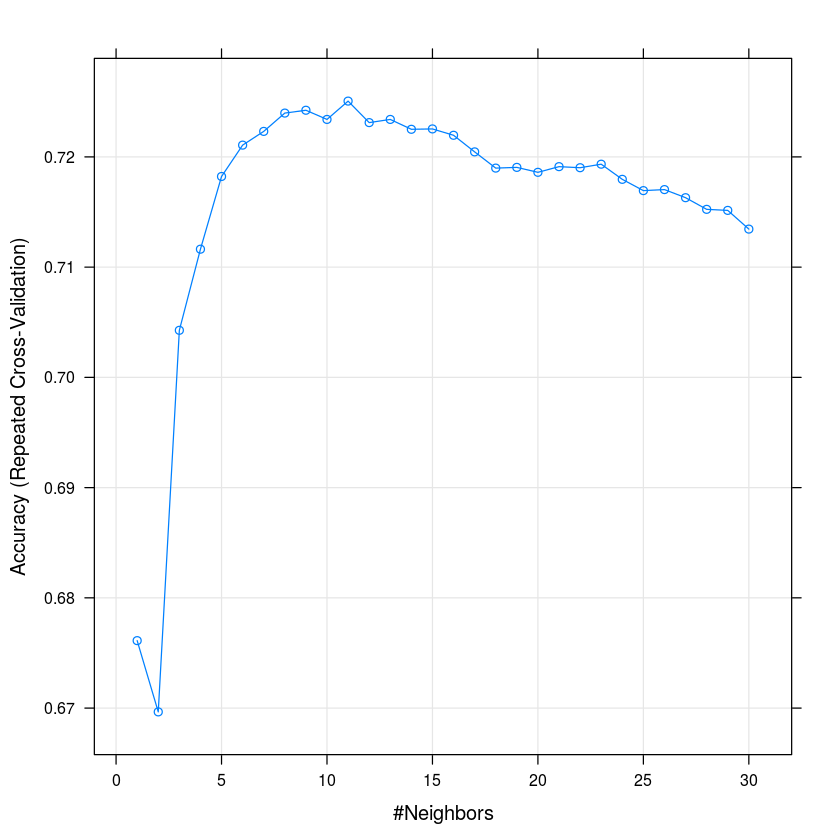

In [47]:
plot(KNN_fit)

A K of 11 seems to be optimal.

#### Generate predictions

In [82]:
# Change dtypes
KNN_test$activity = as.character(KNN_test$activity)
KNN_test$PC1 = as.numeric(as.character(KNN_test$PC1))
KNN_test$PC2 = as.numeric(as.character(KNN_test$PC2))
KNN_test$PC3 = as.numeric(as.character(KNN_test$PC3))
KNN_test$PC4 = as.numeric(as.character(KNN_test$PC4))
KNN_test$PC5 = as.numeric(as.character(KNN_test$PC5))

# Get predictions
prediction = knn(KNN_train[-1], KNN_test[-1], KNN_train[,1], 11)
KNN_test$activity = prediction

# Bind it with previous stuff
myData = cbind(KNN_test[1], KNN_unnecessary_test)

# Pad to 2 digits
myData$exp_id = sprintf("%02d", myData$exp_id)
myData$user_id = sprintf("%02d", myData$user_id)

In [85]:
myData %>%
  mutate(user_id = paste("user", user_id, sep=""), exp_id = paste("exp", exp_id, sep="")) %>%
  unite(Id, user_id, exp_id, sample) %>%
  select(Id, Predicted = activity) %>%
  mutate(Predicted = Predicted) %>%
  write_csv("test_set_predictions_k11.csv")